#ChungliAo_Bert_and_Tokenizer

In [1]:
!pip install -Uq adapters
!pip install -q datasets
!pip install -q accelerate
!pip install pyarrow==8.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which 

In [2]:
import pandas as pd
from datasets import Dataset
from adapters import AutoAdapterModel
from transformers import AutoTokenizer, TrainingArguments, EvalPrediction
from adapters import AdapterTrainer
import torch
import numpy as np
from adapters.composition import Fuse
from sklearn.model_selection import train_test_split

#Train data

In [3]:
df1 = pd.read_excel("/content/Chungli_ao_Train.xlsx")
df2 = pd.read_excel("/content/mizo_sentiment_dataset.xlsx")

In [4]:
#df = df1 #Chungli Ao
#df = df2 #Mizo
df = pd.concat([df1, df2])

In [5]:
df.head()

,Text,Sentiment,__index_level_0__
0,Kohima nung nisung asem Tang tashi nung tashid...,POSITIVE,NaN
1,"asenok ajak semdangtsü imlaa Paisa, nüburtem d...",POSITIVE,NaN
2,Iba shisadokden senden nung atema senden nung ...,POSITIVE,NaN
3,Iba senden nung Chief menogo. Iba senden nung ...,POSITIVE,NaN
4,Iba senden nung 2021-22 atema V AC tasen ka as...,POSITIVE,NaN


In [6]:
# Here, I loaded the train and test datasets from excel.
trainDf = df
testDf = pd.read_excel('/content/Chungli_Ao_test.xlsx')

In [7]:
# Drop the __index_level_0__ column
trainDf.drop(columns=['__index_level_0__'], inplace=True)

In [8]:
trainDf.head()

,Text,Sentiment
0,Kohima nung nisung asem Tang tashi nung tashid...,POSITIVE
1,"asenok ajak semdangtsü imlaa Paisa, nüburtem d...",POSITIVE
2,Iba shisadokden senden nung atema senden nung ...,POSITIVE
3,Iba senden nung Chief menogo. Iba senden nung ...,POSITIVE
4,Iba senden nung 2021-22 atema V AC tasen ka as...,POSITIVE


In [9]:
# Here, I did mapping of sentiment labels to integers.
labelMapping = {"POSITIVE": 1, "NEGATIVE": 0}

In [10]:
# Here, I applied the mapping to the train and test datasets
trainDf["Sentiment"] = trainDf["Sentiment"].map(labelMapping)
testDf["Sentiment"] = testDf["Sentiment"].map(labelMapping)

In [11]:
# Here, I split the training data into training and validation sets into 80 & 20 percent
trainDf, valDf = train_test_split(trainDf, test_size=0.2, random_state=42)

In [12]:
trainDf.head()

,Text,Sentiment
2592,"League dak sendakba nung sensaksemtsü, saka Na...",0
4366,Tarutsü asoshi tajungba dang iba maparen nungi...,1
174,APP hi a tha ani ber lo..mihring te an pawimaw...,0
6275,semogo. Upamecano ya taruba season Munich nung...,0
2577,Hei hi mihring inlaichinna buaithlak tak takte...,1


In [13]:
# Here, I converted the dataframes to datasets
trainDataset = Dataset.from_pandas(trainDf)
valDataset = Dataset.from_pandas(valDf)
testDataset = Dataset.from_pandas(testDf)

In [14]:
# Here, I loaded tokenizer and base model of Chungli Ao
tokenizer = AutoTokenizer.from_pretrained("Blue7Bird/chungli_ao_bert_model")
model = AutoAdapterModel.from_pretrained("Blue7Bird/chungli_ao_bert_model")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/169k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/504k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

In [15]:
# Here, I loaded the adapters of Chungli ao and Mizo
model.load_adapter("tona3738/my-chungliao-adapter", load_as="myChungliaoAdapter", set_active=True)
model.load_adapter("tona3738/my-mizo-adapter", load_as="myMizoAdapter", set_active=True)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/919 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

head_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

pytorch_model_head.bin:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/adapters/loading.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_file, map_location="cpu")


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

head_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/891 [00:00<?, ?B/s]

pytorch_adapter.bin:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

pytorch_model_head.bin:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

'myMizoAdapter'

In [16]:
# Here, I did the adapter fusion
adapterSetup = Fuse("myChungliaoAdapter", "myMizoAdapter")
model.add_adapter_fusion(adapterSetup)

In [17]:
# Here I froze the base model and train only the adapters
model.train_adapter(adapterSetup)

In [18]:
# Here I added a classification head for the target task
numLabels = 2  # Here I adjusted this to the number of labels in the dataset
model.add_classification_head(
    "chungliAoTask",
    num_labels=numLabels,
    id2label={0: "NEGATIVE", 1: "POSITIVE"}
)

# Here I created a function to encode the dataset
def encodeBatch(batch):
    encoding = tokenizer(
        batch["Text"],
        max_length=180,
        truncation=True,
        padding="max_length",
    )
    encoding["labels"] = batch["Sentiment"]
    return encoding

In [19]:
# Here I encoded the datasets
trainDataset = trainDataset.map(encodeBatch, batched=True)
valDataset = valDataset.map(encodeBatch, batched=True)
testDataset = testDataset.map(encodeBatch, batched=True)

Map:   0%|          | 0/9039 [00:00<?, ? examples/s]

Map:   0%|          | 0/2260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [20]:
# Here I set the format for PyTorch for the dataset
trainDataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valDataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
testDataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# Here , I defined the evaluation metrics
#def computeAccuracy(p: EvalPrediction):
   # preds = np.argmax(p.predictions, axis=1)
    #return {"acc": (preds == p.label_ids).mean()}

In [21]:
!pip install wandb
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


In [22]:
# Here, I initialized the weights & biases
wandb.init(project='Roboust_nlp_error_analysis', name='Error_analysis')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback

In [24]:
# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {'Accuracy': acc, 'F1': f1, 'Precision': precision, 'Recall': recall}

In [25]:
 #Here, I set up training arguments
trainingArgs = TrainingArguments(
    learning_rate=0.0001,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=10,
    output_dir="./training_output",
    logging_dir='./logs',
    overwrite_output_dir=True,
    remove_unused_columns=False,
    fp16=True,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    eval_steps=10,
    load_best_model_at_end=True,  # Here, I load the best model
    report_to='wandb',
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.001,
)

# Here, I initialized the trainer with the training arguments
trainer = AdapterTrainer(
    model=model,
    args=trainingArgs,
    train_dataset=trainDataset,
    eval_dataset=valDataset,  # Here I used the validation dataset for evaluation during training
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Here I trained the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.837000,0.821885,0.158407,0.158407,0.158407,0.158407
20,0.785000,0.755239,0.163274,0.163274,0.163274,0.163274
30,0.706800,0.656558,0.587168,0.587168,0.587168,0.587168
40,0.608200,0.548252,0.850885,0.850885,0.850885,0.850885
50,0.502000,0.458473,0.850885,0.850885,0.850885,0.850885
60,0.415400,0.408053,0.850000,0.850000,0.850000,0.850000
70,0.454000,0.398875,0.850000,0.850000,0.850000,0.850000
80,0.410400,0.398906,0.850000,0.850000,0.850000,0.850000
90,0.430900,0.397962,0.849558,0.849558,0.849558,0.849558
100,0.413400,0.396531,0.848230,0.848230,0.848230,0.848230


/usr/local/lib/python3.10/dist-packages/adapters/loading.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_file, map_location="cpu")


TrainOutput(global_step=846, training_loss=0.33527124998980945, metrics={'train_runtime': 668.155, 'train_samples_per_second': 40.585, 'train_steps_per_second': 1.266, 'total_flos': 3229530200323200.0, 'train_loss': 0.33527124998980945, 'epoch': 2.994690265486726})

In [26]:
# Here, I evaluated the model
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.31797122955322266, 'eval_Accuracy': 0.8880530973451327, 'eval_F1': 0.8880530973451327, 'eval_Precision': 0.8880530973451327, 'eval_Recall': 0.8880530973451327, 'eval_runtime': 5.842, 'eval_samples_per_second': 386.854, 'eval_steps_per_second': 24.307, 'epoch': 2.994690265486726}


In [38]:
# Here, I EvaluateD the model on the test dataset
testEvalResult = trainer.evaluate(eval_dataset=testDataset)
print(testEvalResult)

#Pushing_to_hugging_face

In [31]:
from huggingface_hub import login
login()

In [32]:
from huggingface_hub import create_repo

# Create a new repository with the desired name
repo_name = "Roboust_nlp_Adapter_Fusion"  # Desired repository name
create_repo(repo_name)

RepoUrl('https://huggingface.co/Blue7Bird/Roboust_nlp_Adapter_Fusion', endpoint='https://huggingface.co', repo_type='model', repo_id='Blue7Bird/Roboust_nlp_Adapter_Fusion')

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Blue7Bird/chungli_ao_bert_model")
model = AutoModelForSequenceClassification.from_pretrained("Blue7Bird/chungli_ao_bert_model")

In [34]:
model.save_pretrained("/content/training_output")
tokenizer.save_pretrained("/content/training_output")

('/content/training_output/tokenizer_config.json',
 '/content/training_output/special_tokens_map.json',
 '/content/training_output/vocab.txt',
 '/content/training_output/added_tokens.json',
 '/content/training_output/tokenizer.json')

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/content/training_output")
model = AutoModelForSequenceClassification.from_pretrained("/content/training_output")

In [37]:
model.push_to_hub("Blue7Bird/Roboust_nlp_Adapter_Fusion")
tokenizer.push_to_hub("Blue7Bird/Roboust_nlp_Adapter_Fusion")

model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Blue7Bird/Roboust_nlp_Adapter_Fusion/commit/dd8c4acd3bd101131a950c145d0c724447de5b7a', commit_message='Upload tokenizer', commit_description='', oid='dd8c4acd3bd101131a950c145d0c724447de5b7a', pr_url=None, pr_revision=None, pr_num=None)

#Error_analysis

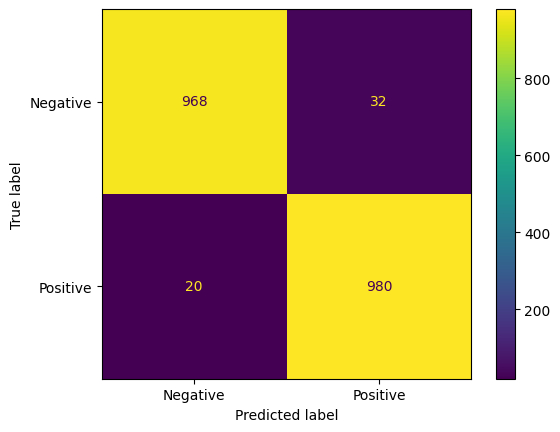

In [39]:
# Make predictions on the test dataset using the trained model
test_predictions = trainer.predict(testDataset)

# Convert the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Assign the predicted labels to a new column in the test dataframe
testDf['Predicted_Label'] = pred_labels

# Create a new column in the test dataframe that checks if the predicted label matches the true label
testDf['Correct'] = testDf['Sentiment'] == testDf['Predicted_Label']

# Filter the dataframe to include only the rows where the prediction was incorrect
misclassified = testDf[testDf['Correct'] == False]

# Display the columns 'Text', 'Sentiment', and 'Predicted_Label' from the misclassified examples
misclassified_examples = misclassified[['Text', 'Sentiment', 'Predicted_Label']]
print(misclassified_examples)

# Save the misclassified examples into a dataframe
misclassified_df = misclassified[['Text', 'Sentiment', 'Predicted_Label']]

file_path = 'misclassified_ChungliAO_test.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Create a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(testDf['Sentiment'], testDf['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

# See which labels are misclassified
category_errors = misclassified.groupby('Sentiment').size()
category_errors.index = category_errors.index.map({0: 'Negative', 1: 'Positive'})
print(category_errors)
